<a href="https://colab.research.google.com/github/japeshmethuku17/imagenette_6class/blob/master/CNN_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Development of a VGG-Baseline Convolutional Neural Network Model to classify images from Imagenette_6class dataset.**





# **Step 1: Import the required libraries**

In [0]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import optimizers
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.layers import Input, Add, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
import pydot
from matplotlib.pyplot import imshow
import scipy.misc
import os 
import glob
import gc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import zipfile
from google.colab import drive
import seaborn as sns
from time import time
print("tensorflow version:",tf.__version__)

tensorflow version: 2.2.0-rc2


# **Step 2: Mount Google Drive and load the data**

In [0]:
drive.mount('/content/drive/', force_remount=True)

zip_ref = zipfile.ZipFile("/content/drive/My Drive/imagenette_6class.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Checking the availability of GPU for computing**

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Step 3: Using ImageDataGenerator to feed the images into the neural network**

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
train_data = train_datagen.flow_from_directory('/tmp/train/', class_mode='categorical', target_size=(224,224), batch_size=32)
test_data = test_datagen.flow_from_directory('/tmp/test/', class_mode='categorical', target_size=(224,224), batch_size=32,shuffle=False)
valid_data = valid_datagen.flow_from_directory('/tmp/validation/', class_mode='categorical', target_size=(224,224), batch_size=32,shuffle=False)

Found 7200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


**Displaying the number of classes**

In [0]:
for data_batch, labels_batch in train_data:
    print('Data batch:', data_batch.shape)
    print('Labels batch:', labels_batch.shape)
    print('Number of classes:',labels_batch.shape[1])
    break

Data batch: (32, 224, 224, 3)
Labels batch: (32, 6)
Number of classes: 6


**Displaying a sample image from one of the classes in Test Data**

This is just a sample image from the test data.


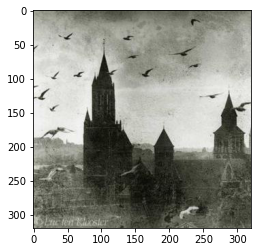

In [0]:
#Loading the image by passing image filepath
img = load_img("/tmp/test/church/ILSVRC2012_val_00034021.JPEG")
x = img_to_array(img)  
plt.imshow(img)
print('This is just a sample image from the test data.')

# **Step 4: Design the Convolutional Neural Network model**

In [0]:
print('Build the CNN model')
model =models.Sequential()
#Block 1
model.add(layers.Conv2D(32, kernel_size=(3, 3), dilation_rate=(1,1), padding = 'same', strides=(1,1), kernel_initializer='glorot_uniform', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), dilation_rate=(1,1), padding = 'same', strides=(1,1), kernel_initializer='glorot_uniform', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#Block 2
model.add(layers.Conv2D(64, kernel_size=(3, 3), dilation_rate=(1,1), padding = 'same', strides=(1,1), kernel_initializer='glorot_uniform', activation='relu'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), dilation_rate=(1,1), padding = 'same', strides=(1,1), kernel_initializer='glorot_uniform', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#Classification block
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_initializer='glorot_uniform',activation='relu'))
model.add(layers.Dense(6,activation='softmax'))
model.summary()
print('The CNN model is now ready for training the images. Go ahead and compile the model')

Build the CNN model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 

**Compile the designed CNN model**

In [0]:
learning_rate= 1e-3  
model.compile(loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=learning_rate),
    metrics=['accuracy'])
print('Model compiled')

Model compiled


In [0]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath = 'vgg-augment-model.h5',
        monitor = 'val_loss',
        save_best_only = True)
    #callbacks.ReduceLROnPlateau(
     #   monitor = 'val_loss',
      #  factor = 0.1,
       # patience = 5),
   # callbacks.CSVLogger(
    #    filename='vgg-baseline-model.csv',
      #  separator = ',',
     #   append = False)
]

# **Step 5: Train the model**

> Feed the training data and evaluate the model on validation data.

> Choose the number of epochs and calculate the time it takes for the model to learn the data.

> Augment the training data before fitting the model.






In [0]:
augment_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
training_dir = '/tmp/train/'
testing_dir = '/tmp/test/'
validation_dir = '/tmp/validation/'
augmented_train_data = augment_data.flow_from_directory(
    training_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')
print('Training data has been augmented!!')

Found 7200 images belonging to 6 classes.
Training data has been augmented!!


In [0]:
print('Fit the model...')
t0 = time() #timing counter starts
print('The model has started learning...')
nepochs=30
print('The model will be trained on',nepochs,'epochs')
batch_size=32
history=model.fit(augmented_train_data, #Learning process starts
                  steps_per_epoch=7200//batch_size,
                  epochs=nepochs,
                  validation_data=valid_data,
                  validation_steps=600//batch_size,
                  callbacks=callbacks_list)
print('Fit model took', int(time() - t0),'s') #time is calculated with the help of counter

Fit the model...
The model has started learning...
The model will be trained on 30 epochs
Epoch 1/30
225/225 [==============================] - 106s 472ms/step - loss: 2.1913 - accuracy: 0.3450 - val_loss: 1.3789 - val_accuracy: 0.4722
Epoch 2/30
225/225 [==============================] - 106s 472ms/step - loss: 1.3298 - accuracy: 0.5096 - val_loss: 1.1164 - val_accuracy: 0.5851
Epoch 3/30
225/225 [==============================] - 106s 472ms/step - loss: 1.1635 - accuracy: 0.5807 - val_loss: 0.9232 - val_accuracy: 0.6719
Epoch 4/30
225/225 [==============================] - 107s 474ms/step - loss: 1.0499 - accuracy: 0.6219 - val_loss: 0.8402 - val_accuracy: 0.7083
Epoch 5/30
225/225 [==============================] - 104s 461ms/step - loss: 0.9561 - accuracy: 0.6610 - val_loss: 0.8846 - val_accuracy: 0.6892
Epoch 6/30
225/225 [==============================] - 104s 460ms/step - loss: 0.9089 - accuracy: 0.6829 - val_loss: 1.3141 - val_accuracy: 0.5521
Epoch 7/30
225/225 [==============

# **Step 6: Evaluate the model**

> Plot the learning curves.

> Produce a classification report that explains the performance of the model.





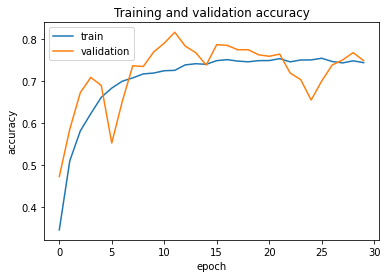

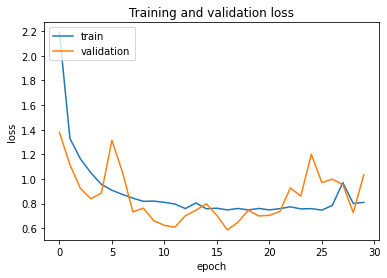

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('VGG-With Augmentation Accuracy', dpi=250)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('VGG-With Augmentation Loss', dpi=250)
plt.show()

**Evaluating the model.**

In [0]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
evaluate_datagen = validation_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 600 images belonging to 6 classes.


In [0]:
print('Evaluating the model')
t0 = time()
evaluate_datagen.reset()
val_predict = model.predict(
    evaluate_datagen,
    steps = 600,
    verbose = 1)
print('Time taken to evaluate the model:',int(time()-t0),'seconds')

Evaluating the model
600/600 [==============================] - 3s 5ms/step
Time taken to evaluate the model: 3 seconds


In [0]:
validation_samples = val_predict.shape[0]
print('Number of data points in validation set:',validation_samples)

Number of data points in validation set: 600


In [0]:
val_predicted_classes = np.argmax(val_predict, axis = 1)
val_true_classes = evaluate_datagen.classes
val_class_labels = list(evaluate_datagen.class_indices.keys())

**Validation Data Classification Report**

In [0]:
validation_report = metrics.classification_report(val_true_classes, val_predicted_classes, target_names=val_class_labels)
print('The validation report is as follows:')
print(validation_report)

The validation report is as follows:
                  precision    recall  f1-score   support

English_springer       0.82      0.81      0.81       100
          church       0.51      0.93      0.65       100
   garbage_truck       0.89      0.54      0.67       100
        gas_pump       0.74      0.63      0.68       100
       parachute       0.92      0.84      0.88       100
           tench       0.91      0.73      0.81       100

        accuracy                           0.75       600
       macro avg       0.80      0.75      0.75       600
    weighted avg       0.80      0.75      0.75       600



In [0]:
val_conf_matrix = tf.math.confusion_matrix(labels=val_true_classes, predictions=val_predicted_classes).numpy()

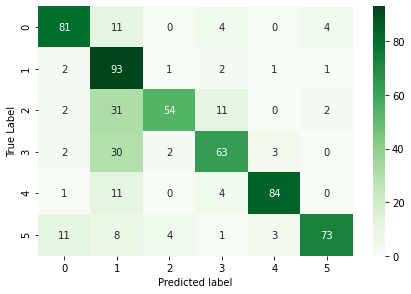

In [0]:
import seaborn as sns
figure1 = plt.figure()
sns.heatmap(val_conf_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Validation data Confusion Matrix_v3', dpi=250)
plt.show()

# **Step 7: Performance measurement on Test data**

In [0]:
testing_datagen = ImageDataGenerator(rescale = 1./255)
test_data_datagen = testing_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 300 images belonging to 6 classes.


In [0]:
print('Testing the model')
final_result = model.evaluate(
    test_data_datagen,
    steps = 300)

Testing the model
300/300 [==============================] - 2s 5ms/step - loss: 0.7873 - accuracy: 0.8167


In [0]:
test_data_datagen.reset()
predict_on_test_data = model.predict(
    test_data_datagen,
    steps = 300,
    verbose = 1
)

300/300 [==============================] - 1s 5ms/step


In [0]:
print('Number of data points in test set:',predict_on_test_data.shape[0])

Number of data points in test set: 300


In [0]:
predicted_classes = np.argmax(predict_on_test_data,axis=1)
predict_true_classes = test_data_datagen.classes
predict_class_labels = list(test_data_datagen.class_indices.keys())

In [0]:
test_report = metrics.classification_report(predict_true_classes, predicted_classes, target_names = predict_class_labels)
print(test_report)

                  precision    recall  f1-score   support

English_springer       0.83      0.90      0.87        50
          church       0.61      0.86      0.72        50
   garbage_truck       0.92      0.70      0.80        50
        gas_pump       0.83      0.76      0.79        50
       parachute       0.88      0.88      0.88        50
           tench       0.95      0.80      0.87        50

        accuracy                           0.82       300
       macro avg       0.84      0.82      0.82       300
    weighted avg       0.84      0.82      0.82       300



In [0]:
test_confusion_matrix = tf.math.confusion_matrix(labels=predict_true_classes,predictions = predicted_classes).numpy()

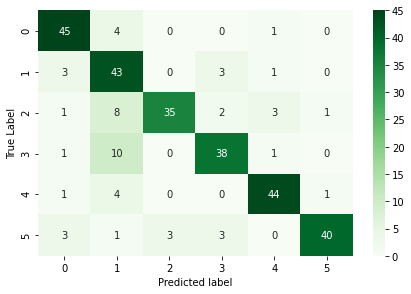

In [0]:
figure1 = plt.figure()
sns.heatmap(test_confusion_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Test data Confusion Matrix_v3', dpi=250)
plt.show()

# **Step 8: Save and load the model**

In [0]:
model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)
  #serializing the weights to HDF5
model.save('VGG-CNN-Augmentation-Model.h5')
print('Model saved to the disk')

Model saved to the disk


In [0]:
json_file = open('model.json','r')
loaded_json_model = json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_json_model)
loaded_model.load_weights("VGG-CNN-Augmentation-Model.h5")
print("Loaded the model from disk")

Loaded the model from disk


# **Author: Japesh Methuku**